# Sample Dataset Creation
This notebook builds a representative sample dataset of 2,000 observations from the full dataset at `../data/data.csv`. It preserves the distribution of the `iconic_taxon_name` field so the sample mimics the original class balance.


In [ ]:
import csv
import math
import random
from collections import defaultdict, Counter
from pathlib import Path

DATA_PATH = Path("..") / "data" / "data.csv"
OUTPUT_PATH = Path("..") / "data" / "sample_data.csv"
SAMPLE_SIZE = 2000
RANDOM_SEED = 42

random.seed(RANDOM_SEED)


In [ ]:
def load_rows_grouped(path):
    grouped = defaultdict(list)
    header = None
    with path.open(newline="") as handle:
        reader = csv.DictReader(handle)
        header = reader.fieldnames
        for row in reader:
            grouped[row.get("iconic_taxon_name") or "UNKNOWN"].append(row)
    if not header:
        raise RuntimeError("Input CSV appears to be empty or missing header.")
    return header, grouped


def largest_remainder_allocation(group_counts, total_size):
    total_rows = sum(group_counts.values())
    allocations = {}
    remainders = []
    allocated = 0
    for category, count in group_counts.items():
        raw = total_size * count / total_rows
        base = math.floor(raw)
        allocations[category] = base
        allocated += base
        remainders.append((raw - base, category))
    remaining = total_size - allocated
    remainders.sort(reverse=True)
    for idx in range(remaining):
        frac, category = remainders[idx]
        allocations[category] += 1
    return allocations


def stratified_sample(grouped_rows, header, output_path, total_size):
    counts = {category: len(rows) for category, rows in grouped_rows.items()}
    if total_size > sum(counts.values()):
        raise ValueError("Requested sample size exceeds available rows.")
    allocations = largest_remainder_allocation(counts, total_size)
    selected = []
    for category, rows in grouped_rows.items():
        need = allocations.get(category, 0)
        if need:
            selected.extend(random.sample(rows, need))
    random.shuffle(selected)
    with output_path.open("w", newline="") as handle:
        writer = csv.DictWriter(handle, fieldnames=header)
        writer.writeheader()
        writer.writerows(selected)
    return selected, allocations


header, grouped_rows = load_rows_grouped(DATA_PATH)
original_counts = Counter(
    {category: len(rows) for category, rows in grouped_rows.items()}
)
sampled_rows, allocation = stratified_sample(
    grouped_rows, header, OUTPUT_PATH, SAMPLE_SIZE
)
sampled_counts = Counter(
    row.get("iconic_taxon_name") or "UNKNOWN" for row in sampled_rows
)

print(f"Wrote {len(sampled_rows)} rows to {OUTPUT_PATH}")
print("\nOriginal distribution:")
for category, count in original_counts.most_common():
    print(f"  {category}: {count}")
print("\nSample distribution:")
for category, count in sampled_counts.most_common():
    print(f"  {category}: {count}")


In [ ]:
print("First five sampled rows:")
for row in sampled_rows[:5]:
    print(
        {
            key: row[key]
            for key in ("id", "iconic_taxon_name", "common_name", "scientific_name")
        }
    )


In [4]:
import pandas as pd

sample_data = pd.read_csv(OUTPUT_PATH)

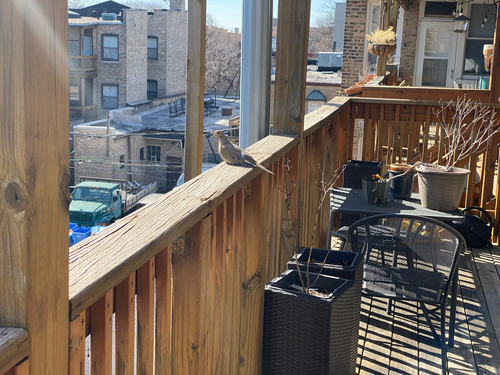

In [ ]:
import requests
from PIL import Image
from io import BytesIO

sample = sample_data[sample_data.uuid == "1ae520bc-f748-42d4-b14d-484bb937c5c6"]
img = requests.get(sample.image_url.values[0]).content
img = Image.open(BytesIO(img))
display(img)
